In [1]:
'''
04/27 update:
1. Updated Cell 6
2. Added data exploration, undersampling
3. Preliminary modeling and model eval
4. Saved models

04/26 update:
1. Added Cell 6

'''

'\n04/27 update:\n1. Updated Cell 6\n2. Added data exploration, undersampling\n3. Preliminary modeling and model eval\n4. Saved models\n\n04/26 update:\n1. Added Cell 6\n\n'

In [2]:
import pandas as pd
import datetime

In [3]:
dt = datetime.datetime

In [4]:
def removeUTC(date_string):
    '''
    Removes the +00 in UTC datetime string
    '''
    return date_string.split("+")[0]

In [9]:
df = pd.read_csv("C:\\Users\\ASUS\\Desktop\\New folder\\EVCS_Energy.csv.csv")

In [10]:
# dropping all rows with NaN
df.dropna(inplace=True)

In [11]:
df = df.reset_index()
threshold = pd.Timedelta(hours=96)
rows_to_drop = []


for idx, _ in df.iterrows():
    
    start_time = pd.to_datetime(df.iloc[idx]['Start_Date___Time'])
    end_time = pd.to_datetime(df.iloc[idx]['End_Date___Time'])
    
    if (end_time - start_time) >= threshold:
        rows_to_drop.append(idx)
        continue
    
    duration = pd.to_timedelta(df.iloc[idx]['Total_Duration__hh_mm_ss_'])
    
    if ((end_time - start_time) - duration) > pd.Timedelta(minutes=1):
        rows_to_drop.append(idx)

df = df.drop(rows_to_drop)

In [12]:
# creating a dictionary for storing station information for easier access
station_names = set(df['Station_Name'])
zeros = [0]*len(station_names)

station_dict = dict(zip(station_names, zeros))
# station_dict

In [13]:
split_sessions = []
df_hourly_col = ['Station_Name', 'Address', 'City', 'State_Province', 'Zip','Year', 'Month', 'Date', 'DayOfWeek','Start_Hour', 'Minutes_Occupied_Per_Hour']

# increments time by 1 hour
delta = datetime.timedelta(hours=1)

for idx, session in df.iterrows():
    
    # calculating start and end times for each session
    start_time = dt.strptime(removeUTC(session['Start_Date___Time']), '%Y/%m/%d %H:%M:%S')
    end_time = dt.strptime(removeUTC(session['End_Date___Time']), '%Y/%m/%d %H:%M:%S')
    station = session['Station_Name']
    # print(station, start_time, end_time)
    
    # updating the station_dict info for every new station
    if station_dict[station] == 0:
        station_dict[station] = {
            'address': session['Address'],
            'city': session['City'],
            'state': session['State_Province'],
            'zip': session['Zip_Postal_Code']
        }
    
    station_info = (station, station_dict[station]['address'], station_dict[station]['city'], station_dict[station]['state'], station_dict[station]['zip'])
    
    current_time = start_time
    while not current_time > end_time:
        # print(current_time)
        
        # Handling edge case for start and end time in the same hour
        if start_time.replace(minute=0, second=0) == end_time.replace(minute=0, second=0):
            split_sessions.append(station_info + (start_time.year, start_time.month, start_time.day, start_time.isoweekday(),start_time.hour, (end_time - start_time).seconds / 60))
            current_time += delta
        
        # Getting occupancy rate for first hour of session
        elif current_time == start_time:
            rightbound = start_time.replace(minute=0, second=0) + delta
            split_sessions.append(station_info + (start_time.year, start_time.month, start_time.day, start_time.isoweekday(),start_time.hour, (rightbound - start_time).seconds / 60))
            current_time = rightbound
        
        # Getting occupancy for last hour of session
        elif current_time >= end_time.replace(minute=0, second=0):
            leftbound = end_time.replace(minute=0, second=0)
            split_sessions.append(station_info + (end_time.year, end_time.month, end_time.day, end_time.isoweekday(), end_time.hour, (end_time - leftbound).seconds / 60))
            current_time += delta
        
        else:
            split_sessions.append(station_info + (current_time.year, current_time.month, current_time.day, current_time.isoweekday(), current_time.hour, 60))
            current_time += delta
        
# create a new DataFrame from the split sessions
df_split = pd.DataFrame(split_sessions, columns=df_hourly_col)

In [14]:
df_split
# df_split.info()

,Station_Name,Address,City,State_Province,Zip,Year,Month,Date,DayOfWeek,Start_Hour,Minutes_Occupied_Per_Hour
0,BOULDER / BASELINE ST1,900 Baseline Rd,Boulder,Colorado,80302,2018,1,20,6,7,31.0
1,BOULDER / BASELINE ST1,900 Baseline Rd,Boulder,Colorado,80302,2018,1,20,6,8,60.0
2,BOULDER / BASELINE ST1,900 Baseline Rd,Boulder,Colorado,80302,2018,1,20,6,9,22.0
3,BOULDER / BASELINE ST1,900 Baseline Rd,Boulder,Colorado,80302,2018,2,9,5,16,3.0
4,BOULDER / BASELINE ST1,900 Baseline Rd,Boulder,Colorado,80302,2018,2,9,5,17,60.0
...,...,...,...,...,...,...,...,...,...,...,...
208957,BOULDER / BASELINE ST1,900 Baseline Rd,Boulder,Colorado,80302,2023,3,31,5,6,1.0
208958,BOULDER / BASELINE ST1,900 Baseline Rd,Boulder,Colorado,80302,2023,3,31,5,7,60.0
208959,BOULDER / BASELINE ST1,900 Baseline Rd,Boulder,Colorado,80302,2023,3,31,5,8,60.0
208960,BOULDER / BASELINE ST1,900 Baseline Rd,Boulder,Colorado,80302,2023,3,31,5,9,60.0


In [15]:
# create a new dataframe with all possible combinations of Station_Name, Year, Month, Date, and Hour
date_range = pd.date_range(start=df['Start_Date___Time'].min(), end=df['End_Date___Time'].max())
hours = range(0, 24)
all_times = []
columns = ['Station_Name', 'Address', 'City', 'State_Province', 'Zip','Year', 'Month', 'Date', 'DayOfWeek','Start_Hour', 'Minutes_Occupied_Per_Hour']

# Generating complete timeseries for all charging stations
for station in station_dict:
    station_info = (station, station_dict[station]['address'], station_dict[station]['city'], station_dict[station]['state'], station_dict[station]['zip'])
    
    for date in date_range:
        for hour in hours:
            all_times.append(station_info+(date.year, date.month, date.day, date.isoweekday(), hour, 0))
        

total_time_df = pd.DataFrame(all_times, columns=columns)

In [16]:
total_time_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1473024 entries, 0 to 1473023
Data columns (total 11 columns):
 #   Column                     Non-Null Count    Dtype 
---  ------                     --------------    ----- 
 0   Station_Name               1473024 non-null  object
 1   Address                    1473024 non-null  object
 2   City                       1473024 non-null  object
 3   State_Province             1473024 non-null  object
 4   Zip                        1473024 non-null  int64 
 5   Year                       1473024 non-null  int64 
 6   Month                      1473024 non-null  int64 
 7   Date                       1473024 non-null  int64 
 8   DayOfWeek                  1473024 non-null  int64 
 9   Start_Hour                 1473024 non-null  int64 
 10  Minutes_Occupied_Per_Hour  1473024 non-null  int64 
dtypes: int64(7), object(4)
memory usage: 123.6+ MB


In [17]:
# merge the original dataframe with the new dataframe to fill in missing hours and dates
concat_df = pd.concat([total_time_df, df_split], ignore_index=True)

In [18]:
concat_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1681986 entries, 0 to 1681985
Data columns (total 11 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Station_Name               1681986 non-null  object 
 1   Address                    1681986 non-null  object 
 2   City                       1681986 non-null  object 
 3   State_Province             1681986 non-null  object 
 4   Zip                        1681986 non-null  int64  
 5   Year                       1681986 non-null  int64  
 6   Month                      1681986 non-null  int64  
 7   Date                       1681986 non-null  int64  
 8   DayOfWeek                  1681986 non-null  int64  
 9   Start_Hour                 1681986 non-null  int64  
 10  Minutes_Occupied_Per_Hour  1681986 non-null  float64
dtypes: float64(1), int64(6), object(4)
memory usage: 141.2+ MB


In [19]:
# Summing up Minutes_Occupied_Per_Hour for each station
final_df = concat_df.groupby(concat_df.columns[:-1].tolist()).sum().reset_index()

In [20]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1473034 entries, 0 to 1473033
Data columns (total 11 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Station_Name               1473034 non-null  object 
 1   Address                    1473034 non-null  object 
 2   City                       1473034 non-null  object 
 3   State_Province             1473034 non-null  object 
 4   Zip                        1473034 non-null  int64  
 5   Year                       1473034 non-null  int64  
 6   Month                      1473034 non-null  int64  
 7   Date                       1473034 non-null  int64  
 8   DayOfWeek                  1473034 non-null  int64  
 9   Start_Hour                 1473034 non-null  int64  
 10  Minutes_Occupied_Per_Hour  1473034 non-null  float64
dtypes: float64(1), int64(6), object(4)
memory usage: 123.6+ MB


In [21]:
final_df['NumberOfPorts'] = 2

In [22]:
final_df['OccupationRate'] = (final_df['Minutes_Occupied_Per_Hour']/60)/final_df['NumberOfPorts']*100.00

In [23]:
final_df[final_df['OccupationRate'] > 100]

,Station_Name,Address,City,State_Province,Zip,Year,Month,Date,DayOfWeek,Start_Hour,Minutes_Occupied_Per_Hour,NumberOfPorts,OccupationRate


####
#### Data Exploration

In [24]:
# Instance count plot
import matplotlib.pyplot as plt

plt.figure(figsize =(12, 6))
n, bins, _ = plt.hist(final_df[['OccupationRate']], bins=20, range=(0, 100), color='goldenrod', rwidth=0.8)
plt.ylabel('# of instances')
plt.xlabel('Occupation rate (%)') 
plt.title('Occupation Rate Count')
plt.show()

ModuleNotFoundError: No module named 'matplotlib'

In [17]:
# Instance count
pd.DataFrame(data=n, index=[str(bins[i])+' - '+str(bins[i+1]) for i in range(len(bins)-1)], columns=['Instance count'], dtype='int')

,Instance count
0.0 - 5.0,1309421
5.0 - 10.0,7158
10.0 - 15.0,7055
15.0 - 20.0,6867
20.0 - 25.0,6798
25.0 - 30.0,6999
30.0 - 35.0,6924
35.0 - 40.0,6696
40.0 - 45.0,6428
45.0 - 50.0,6565


In [18]:
# Select relevant attributes and construct features/target dataframes
import numpy as np
from sklearn.preprocessing import OneHotEncoder

# Features dataframe
ohe = OneHotEncoder()
features = final_df[['Station_Name','Year', 'Month', 'Date', 'DayOfWeek','Start_Hour']]
features = pd.DataFrame(ohe.fit_transform(features).toarray())

# Target dataframe
target = pd.DataFrame()
target['Available_spot?'] = np.where(final_df['OccupationRate'] >= 50, 1, 0)

features.head()
# target.head()

,0,1,2,3,4,5,6,7,8,9,...,102,103,104,105,106,107,108,109,110,111
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
# Target class statistics
c0 = target[target['Available_spot?'] == 0].count()[0]
c1 = target[target['Available_spot?'] == 1].count()[0]

print(f"    Likely to get a spot (Class 0): {c0:8} instances")
print(f"Not likely to get a spot (Class 1): {c1:8} instances")

    Likely to get a spot (Class 0):  1370911 instances
Not likely to get a spot (Class 1):   102123 instances


####
#### Undersampling

In [20]:
# Class count before undersampling
from collections import Counter

counter = Counter(target['Available_spot?'])
print('Before undersampling:', counter)

Before undersampling: Counter({0: 1370911, 1: 102123})


In [21]:
# Random undersampling
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=11)
features, target = rus.fit_resample(features, target)

# Class count after undersampling
counter = Counter(target['Available_spot?'])
print('After undersampling:', counter)

After undersampling: Counter({0: 102123, 1: 102123})


In [ ]:
'''

### Using OSS undersamling could potentially increase performance but it's currently taking too long to run ###



# One-Sided Selection (OSS) undersampling
from imblearn.under_sampling import OneSidedSelection

undersample = OneSidedSelection(n_neighbors=1, n_seeds_S=200, random_state=11)
features, target = undersample.fit_resample(features, target)

# Class count after undersampling
counter = Counter(target)
print('After undersampling:', counter)

'''

####
#### Modeling and Eval

In [22]:
# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features.to_numpy(), target.to_numpy().flatten(), test_size=0.1, random_state=11)

##### Logistic regression

In [23]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(random_state=11)
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)

In [24]:
# Model evaluation
from sklearn.metrics import confusion_matrix, classification_report

print('Confusion matrix:')
print(confusion_matrix(y_test, y_pred_lr))
print()
print(classification_report(y_test, y_pred_lr, target_names=['Likely to get a spot (Class 0)', 'Not likely to get a spot (Class 1)']))

Confusion matrix:
[[7347 2953]
 [2169 7956]]

                                    precision    recall  f1-score   support

    Likely to get a spot (Class 0)       0.77      0.71      0.74     10300
Not likely to get a spot (Class 1)       0.73      0.79      0.76     10125

                          accuracy                           0.75     20425
                         macro avg       0.75      0.75      0.75     20425
                      weighted avg       0.75      0.75      0.75     20425



##### Linear support vector classifier

In [25]:
from sklearn.svm import LinearSVC
svc = LinearSVC(random_state=11)
svc.fit(X_train, y_train)

y_pred_svc = svc.predict(X_test)

In [26]:
# Model evaluation

print('Confusion matrix:')
print(confusion_matrix(y_test, y_pred_svc))
print()
print(classification_report(y_test, y_pred_svc, target_names=['Likely to get a spot (Class 0)', 'Not likely to get a spot (Class 1)']))

Confusion matrix:
[[7282 3018]
 [2143 7982]]

                                    precision    recall  f1-score   support

    Likely to get a spot (Class 0)       0.77      0.71      0.74     10300
Not likely to get a spot (Class 1)       0.73      0.79      0.76     10125

                          accuracy                           0.75     20425
                         macro avg       0.75      0.75      0.75     20425
                      weighted avg       0.75      0.75      0.75     20425



##### Random forest

In [27]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(max_depth=100, random_state=11)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

In [28]:
# Model evaluation

print('Confusion matrix:')
print(confusion_matrix(y_test, y_pred_rf))
print()
print(classification_report(y_test, y_pred_rf, target_names=['Likely to get a spot (Class 0)', 'Not likely to get a spot (Class 1)']))

Confusion matrix:
[[8519 1781]
 [1067 9058]]

                                    precision    recall  f1-score   support

    Likely to get a spot (Class 0)       0.89      0.83      0.86     10300
Not likely to get a spot (Class 1)       0.84      0.89      0.86     10125

                          accuracy                           0.86     20425
                         macro avg       0.86      0.86      0.86     20425
                      weighted avg       0.86      0.86      0.86     20425



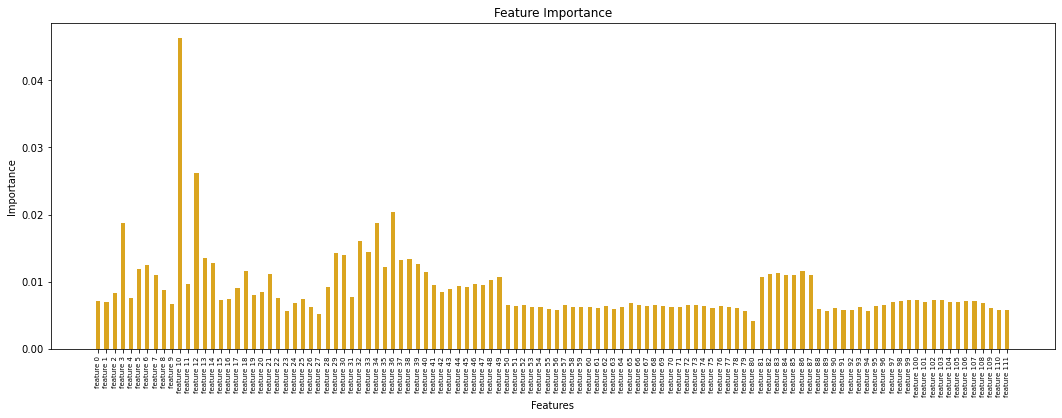

In [29]:
# Feature importance
imp = rf.feature_importances_

plt.figure(figsize =(18, 6))
plt.bar([f"feature {i}" for i in range(len(imp))], imp, color='goldenrod', width=0.5)
plt.ylabel('Importance')
plt.xlabel('Features') 
plt.xticks(rotation=90, fontsize=7)
plt.title('Feature Importance')
plt.show()

##### kNN

In [30]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

y_pred_knn = knn.predict(X_test)

In [31]:
# Model evaluation

print('Confusion matrix:')
print(confusion_matrix(y_test, y_pred_knn))
print()
print(classification_report(y_test, y_pred_knn, target_names=['Likely to get a spot (Class 0)', 'Not likely to get a spot (Class 1)']))

Confusion matrix:
[[6810 3490]
 [1261 8864]]

                                    precision    recall  f1-score   support

    Likely to get a spot (Class 0)       0.84      0.66      0.74     10300
Not likely to get a spot (Class 1)       0.72      0.88      0.79     10125

                          accuracy                           0.77     20425
                         macro avg       0.78      0.77      0.77     20425
                      weighted avg       0.78      0.77      0.76     20425



####
#### Save the Trained Models for Future Use

In [32]:
# Save the models to disk for future use
import pickle

pickle.dump(ohe, open('ohe.sav', 'wb'))
pickle.dump(lr, open('lr_model.sav', 'wb'))
pickle.dump(svc, open('svc_model.sav', 'wb'))
pickle.dump(rf, open('rf_model.sav', 'wb'))
pickle.dump(knn, open('knn_model.sav', 'wb'))

In [ ]:
'''

# Load the model from disk
loaded_ohe = pickle.load(open('ohe.sav', 'rb'))
loaded_lr = pickle.load(open('lr_model.sav', 'rb'))
loaded_svc = pickle.load(open('svc_model.sav', 'rb'))
loaded_rf = pickle.load(open('rf_model.sav', 'rb'))
loaded_knn = pickle.load(open('knn_model.sav', 'rb'))

# Prediction
testset = X_test
lr_result = loaded_lr.predict(testset)
svc_result = loaded_svc.predict(testset)
rf_result = loaded_rf.predict(testset)
knn_result = loaded_knn.predict(testset)

'''

####
#### Predicting Random Testsets with the Saved Models

In [33]:
def available_spot(testset=[[]], model='lr'):
    test_df = pd.DataFrame(columns=['Station_Name','Year', 'Month', 'Date', 'DayOfWeek','Start_Hour'])
    
    for row in testset:
        test_df.loc[len(test_df.index)] = row
    
    loaded_ohe = pickle.load(open('ohe.sav', 'rb'))
    x = loaded_ohe.transform(test_df)
    
    if model == 'lr':
        loaded_lr = pickle.load(open('lr_model.sav', 'rb'))
        result = loaded_lr.predict(x)
    elif model == 'svc':
        loaded_svc = pickle.load(open('svc_model.sav', 'rb'))
        result = loaded_svc.predict(x)
    elif model == 'rf':
        loaded_rf = pickle.load(open('rf_model.sav', 'rb'))
        result = loaded_rf.predict(x)
    elif model == 'knn':
        loaded_knn = pickle.load(open('knn_model.sav', 'rb'))
        result = loaded_knn.predict(x)
    else:
        raise Exception('Invalid model name')
    
    class_dict = {0:'Likely to get a spot (Class 0)', 1:'Not likely to get a spot (Class 1)'}    
    for idx, pred in enumerate(result):
        print(f'Row {idx+1} - Prediction: {class_dict[pred]}')

In [34]:
# Prediction
available_spot(testset=[['BOULDER / AIRPORT ST1', 2018, 1, 1, 1, 0]], model='lr')

Row 1 - Prediction: Likely to get a spot (Class 0)
